# Construção de Banco de Vogais

O objetivo deste projeto é construir um banco de dados que consiste em imagens de algumas vogais do alfabeto. O banco foi feito de forma que se pareça com o famoso MNSIT, pequenas imagens em escala de cinza com um caractere em cada uma. Para tal usamos a segmentação de Otsu para binarizar a imagem em preto e branco, usamos o algoritmo K-means para fazer a localização dos objetos de interesse e fizemos um erosão da imagem inteira para escurecer as letras. Abaixo temos dois exemplos de fotos usadas no processo.


<img src="img/aColagem.jpg" alt="drawing" width="700"/>
Foto original usada para abstrair imagens com letra a

<img src="img/b.JPG" alt="drawing" width="700"/>
Foto original usada para abstrair imagens com letra b


## Bibliotecas usadas
Usamos a biblioteca **OpenCV** em Python para ler uma imagem com a mesma letras escrita várias vezes e processá-la conforme detalharemos abaixo. 

A **matplotlib** é uma boa opção para fazer apresentação de imagens, até melhor que o OpenCV neste caso.

A **numpy**, além de ser a melhor opção para realizar operações em arrays de qualquer dimensão, é utilizada pelo OpenCV. Nesta, as imagens são modeladas como *Numpy Arrays* para aproveitarmos dos algoritmos otimizados do numpy. Esta biblioteca armazena todos os arrays de forma sequencial na memória e se aproveita disso para realizar operações de forma mais eficiente, isto é, mais rápida do que ocorreria numa listas encadeada.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

## Lendo Imagem
Lemos uma imagem colorida mas logo a convertemos em escalas de cinza. Mostramos, só por curiosidade, o histograma numa escala linear e outro numa escala logarítmica da imagem original.

Nota-se que o matplotlib imprime uma imagem com as coordenadas representando o índice dos pixels. A origem está no canto superior esquerdo.

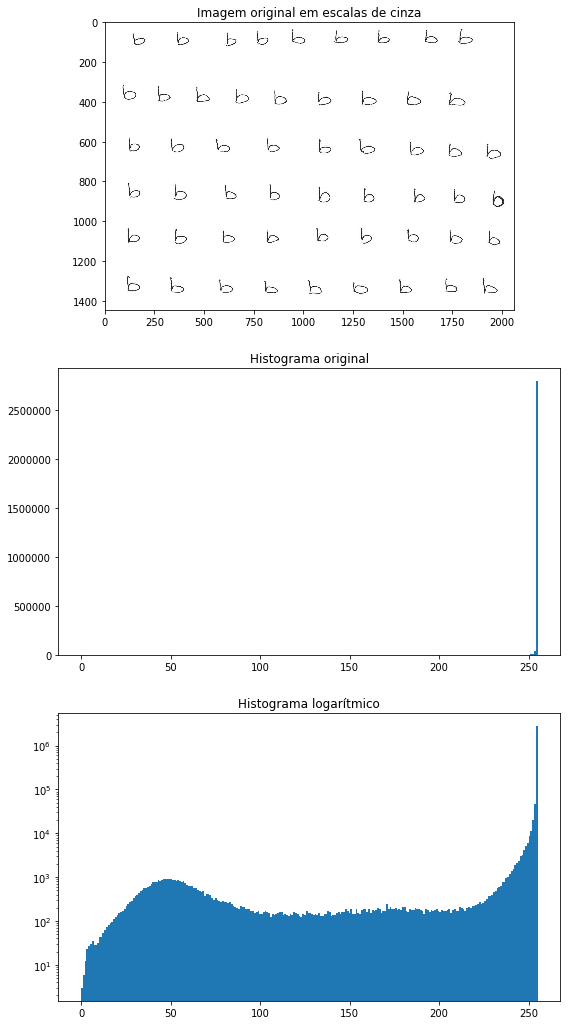

In [2]:
img = cv.imread("/home/victor/Área de Trabalho/OpenCV_Codes/img/b.JPG", cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(9,18))
plt.subplot(3,1,1), plt.imshow(img, cmap='gray')
plt.title('Imagem original em escalas de cinza')

plt.subplot(3,1,2), plt.hist(img.ravel(), 256)
plt.title('Histograma original')

plt.subplot(3,1,3), plt.hist(img.ravel(), 256, log=True)
plt.title('Histograma logarítmico')
plt.show()

## Segmentação de Otsu
Faremos uma segmentação binária na imagem de forma que esta só contenha pixels totalmente brancos, onde não há letra, e totalmente pretos, onde há. Esse processo é necessário para podermos aplicar o algoritmo K-means e, finalmente, encontrar as posições das letras.

O método de Otsu analisa um histograma e escolhe matematicamente um liminar adequado de cinza na qual todas as cores abaixo e acima dele serão extrapolados para os valores extremos de 0 e de 255, respectivamente. Na imagem com letras b anterior, que é uma imagem escaneada, não tem erro pois o contraste entre fundo e objeto é bem grande. Já na foto com letras a, tirada numa iluminação mais pobre, o constraste não é tão grande e o resultado só foi satisfatório porque a iluminação é quase constante em todas as direções. Neste caso, Otsu consegue ser adequado. 

Algumas imagens falharam na segmentação, apesar de parecerem adequadas, devido a iluminação variar muito. Um exemplo disso vemos a seguir.

<img src="img/bteste.jpg" alt="drawing" width="500"/>
<img src="img/bTesteSegmentada.png" alt="drawing" width="500"/>

Neste exemplo, se observarmos o brilho da imagem nos cantos superior esquerdo e inferior direito, notaremos que são bem diferentes.

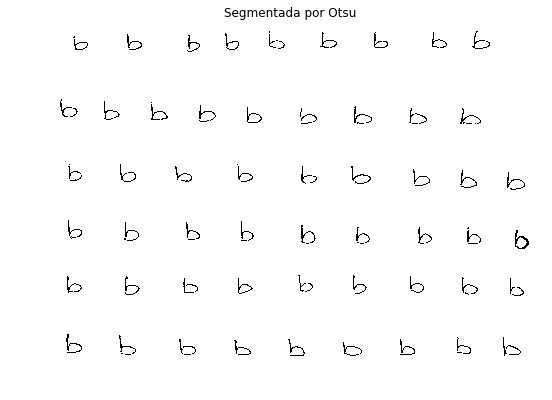

In [3]:
ret, segmentada = cv.threshold(img, 0, 255, cv.THRESH_BINARY+ cv.THRESH_OTSU)

plt.figure(figsize=(9, 18))
plt.axis('off')
plt.imshow(segmentada, cmap='gray'), plt.title('Segmentada por Otsu')
plt.show()

Vemos no histograma da segmentada que há apenas pixels de valor 0 e 255, como queríamos. 

Além disso, a imagem deve ter o mínimo de ruído possível, para que todos os pixels pretos pertençam à letras. Satisfazendo as condições, o resultado é uma clusterização correta.

Quantidade de pixels pretos: [47241.]; brancos: [2935639.]


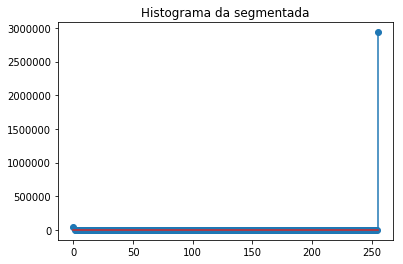

In [4]:
hist = cv.calcHist([segmentada], [0], None, [256], [0, 256])
print('Quantidade de pixels pretos: {}; brancos: {}'.format(hist[0],hist[255]))
plt.stem(hist), plt.title('Histograma da segmentada')
plt.show()

## Salvando Dados para clusterização
Todos os pixels pretos serão salvos numa lista e serão passados como sendo os dados que o K-means se encarregará de agrupar.

In [5]:
pontos = []
rows, cols = segmentada.shape
for i in range(0,rows,3):
    for j in range(0,cols,3):
        if segmentada[i,j] == 0:
          pontos.append(np.array([i,j], dtype = np.float32))  
pontos = np.array(pontos)
print('Quantidade de pontos: {}'.format(len(pontos)))


Quantidade de pontos: 5192


## Erosão
Como as letras foram escritas com caneta fina, o resultado da segmentação nos retornou uma continuidade falha nos contornos de algumas letras. Queremos que as linhas pretas fiquem mais grossas, como se elas estivessem em negrito. Faremos isso com a operação de erosão.

No OpenCV, as operações morfológicas são feitas por padrão na região branca. O que faremos aqui é corroer as bordas brancas e no lugar pôr a cor preta. Se a operação fosse sobre a região preta, teríamos de fazer uma dilatação.

Usamo uma elipse de dimensão 5x5 como elemento estruturante.

<img src="img/efeitoErosao.jpg" alt="drawing" width="500"/>

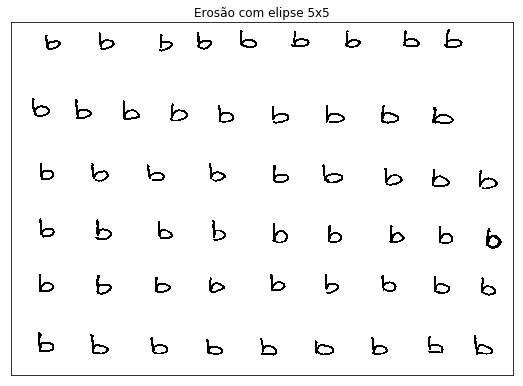

In [6]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))

segmentada = cv.morphologyEx(segmentada, cv.MORPH_ERODE, kernel)
plt.figure(figsize=(9, 18))
plt.imshow(segmentada, cmap='gray'), plt.title('Erosão com elipse 5x5'), plt.xticks([]), plt.yticks([])
plt.show()

## Quantidade de letras
Usaremos o algoritmo **FloodFill** para descobrir a quantidade de letras na imagem. Criamos uma cópia da segmentada para alterar a cor de cada letra num tom de cinza diferente a medida que as encontramos. No fim do processo, elas estarão coloridas nos tons de 1 a K+1 (quantidade de letras). 
A medida que encontramos novos caracteres, é incrementado um contador.

In [7]:
K = 1
img = segmentada.copy()
for i in range(rows):
    for j in range(cols):
        if img[i,j] == 0:
            cv.floodFill(img, None, (j,i), K)
            K+=1
K-=1
print('Quantidade de letras: {}'.format(K))

Quantidade de letras: 54


## Agrupando por K-means
![exemplo](img/k-means.gif)
O K-means requer obrigatoriamente que definamos a quantidade de grupos. Existem métodos matemáticos para estimar essa quantidade em problemas que não a temos a priori, mas isso não faz parte do algoritmo. Neste projeto não há métodos de estimar o K, precisamos conhecer a quantidade de letras na imagem.

Na imagem usada no exemplo, temos "b" 54 vezes. A letras estão espaçadas entre si para facilitar a clusterização e garantir que o resultado obtido é o mais próximo do ótimo. Quando estão muito juntas, é possível que o algoritmo classifique uma dupla como um único cluster. Também é possível dois centros converjirem para o mesmo lugar.

A inicialização adequada dos centros é importante para um bom resultado. Geralmente são iniciado aleatoriamente mas o OpenCV nos dá a opção de usar uma lógica criada por Arthur and Vassilvitskii (2007) definida no código como `cv.KMEANS_PP_CENTERS`. Fonte [neste link](https://docs.opencv.org/2.4/modules/core/doc/clustering.html). Essa lógica não significa que sempre serão iniciados no mesmo lugar, nem mesmo se déssemos os mesmo conjuntos de dados todas as vezes. A aleatoriedade faz parte desse processo, mas tentaremos minimizá-la.

O K-means também requer obrigatorimente pelo menos um critério de parada. Por ser iterativo podemos escolher o número máximo de iterações, que em nosso caso é 10. Outra alternativa é definir um limiar mínimo de variação dos centro entre duas iterações, neste projeto definimos o valor é 1.0. Em cada iteração, é comparada as posições dos centros atuais em relação aos anteriores, calculamos as distâncias percorridas e fazemos uma média. Quando os centros não variam muito, geralmente significa que eles se estagnaram numa resposta que pode ser boa ou péssima, dependendo da posição inicial dos centróides. Tendo esse problema, a implementação do OpenCV tenta contorná-lo executando o algoritmo N vezes com centróides iniciais diferentes e nos retornando o melhor resultado.

Segundo a [documentação](https://docs.opencv.org/2.4/modules/core/doc/clustering.html), a função `cv.kmeans(samples, nclusters, labels, termcrit, attempts=1, flags=0, centers=None)` recebe, na ordem em que aparecem na declaração:
1. Um *numpy array* com os pontos a serem agrupados 
2. A quantidade de clusters
3. O nome dos labels (passamos `None` para não fornecer esses valores)
4. Critérios de parada
5. Quantidade de tentativas (por padrão é 1)
6. Lógica usada para criar centros
7. Centros iniciais definidos pelo usuário (caso não haja, é só ignorar pois `None` é seu valor padrão)

Em retorno, ela nos dá um real representando o quão unidos estão os pontos calculado da seguinte forma:
$U = \sum_{i}||\text{samples}_{i} - \text{centers}_{labels_{i}}||^{2}$. Retorna uma lista com os rótulos dos pontos na mesma ordem em que aparecem nos dados de entrada e o mais importante, os centros.


In [8]:
# K = 54
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flag = cv.KMEANS_PP_CENTERS
compactness, labels, centros = cv.kmeans(pontos, K, None, criteria, 10, flag)

## Visualizando os centros
Vamos desenhar círculos vermelhos nos pontos retornados pela função `kmeans()`. A imagem que estavamos usand oaté o momento foi carregada usando a flag `cv.IMREAD_GRAYSCALE`. Isso quer dizer que cada pixels seu contém 1 Byte, o que nos impossibilita de trabalhar com cores nela. Nós a carregamos novamente usando `cv.IMREAD_COLOR` para poder atribuir em seus pixels uma tupla de 3 elementos, como `(0,0,255)`, representando a cor vermelha.

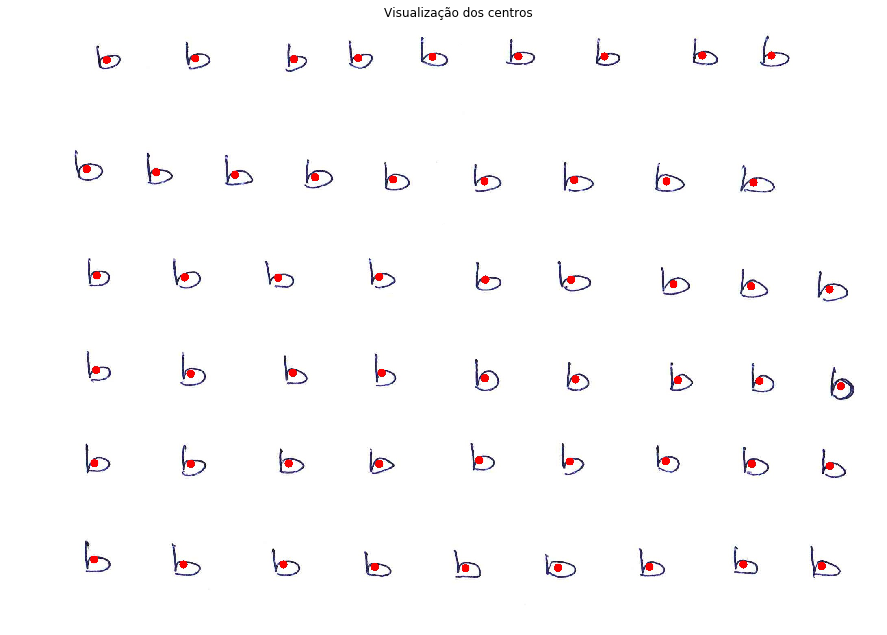

In [9]:
colorida = cv.imread("/home/victor/Área de Trabalho/OpenCV_Codes/img/b.JPG",cv.IMREAD_COLOR)
for lin, col in centros:
    x = int(lin)
    y = int(col)
    cv.circle(colorida, (y,x), 10, (0,0,255), -1)

cv.imwrite('colorida.jpg', colorida)
plt.figure(figsize=(15, 18))
image = mpimg.imread('colorida.jpg')
plt.axis('off')
plt.imshow(image), plt.title('Visualização dos centros')
plt.show()

## Obtendo letras
Com os centros calculados e a imagem pronta, vamos cortar uma região quadrada em torno de cada centro. O tamanho dos quadrados não é fixo, mas adaptável ao tamanho da letra.

Antes de ser salva, a imagem é reduzida a uma matriz 25x25 pois o objetivo é que os 625 pixels sejam as entradas da rede neural que criaremos futuramente.

A função abaixo recebe o tamanho da região que será cortada da imagem segmentada e, caso seja inválido, retorna um tamanho possível, isto é, dentro dos limites da imagem.

In [10]:
def verBordas(xt_m, xt_M, yt_m, yt_M):
    '''
    Recebe as bordas da ROI de 'segmentada' e retorna índices válidos.
    xt_m = x-t
    xt_M = x+t
    yt_m = y-t
    yt_M = y+t
    
    Retorna os índices válidos na mesma ordem que aparecem nos argumentos.
    '''
    rows, cols = segmentada.shape
    if xt_m < 0:
        xt_m = 0
    if xt_M >= rows:
        xt_M = rows-1
    if yt_m < 0:
        yt_m = 0
    if yt_M > cols:
        yt_M = cols-1    
    return xt_m, xt_M, yt_m, yt_M


#SEPARANDO VOGAIS COM TAMANHO ADAPTÁVEL
ind=0
for lin, col in centros:
    tam=3  # tamanho do quadrado inicial
    x = int(lin)
    y = int(col)
    while True:
        t = tam//2
        #VERIFICA SE HÁ UM PIXEL PRETO NA BORDA DO QUADRADO
        borda1 = segmentada[x-t:x+t, y-t:y-t+1].flatten() # vertical esquerda
        borda2 = segmentada[x-t:x+t, y+t:y+t+1].flatten() # vertical direita
        borda3 = segmentada[x-t:x-t+1, y-t:y+t].flatten() # horizontal cima
        borda4 = segmentada[x+t:x+t+1, y-t:y+t].flatten() # horizontal baixo
        bordas = np.append(borda1, [borda2, borda3, borda4]) # mistura tudo
        if 0 in bordas:
            tam+=2
            break
        else: 
            tam+=2  # próximo ímpar
        
    while True:
        t = tam//2
        #VERIFICA SE TODOS OS PIXELS NA BORDA DO QUADRADO SÃO BRANCOS
        borda1 = segmentada[x-t:x+t, y-t:y-t+1].flatten() # vertical esquerda
        borda2 = segmentada[x-t:x+t, y+t:y+t+1].flatten() # vertical direita
        borda3 = segmentada[x-t:x-t+1, y-t:y+t].flatten() # horizontal cima
        borda4 = segmentada[x+t:x+t+1, y-t:y+t].flatten() # horizontal baixo
        bordas = np.append(borda1, [borda2, borda3, borda4]) # mistura tudo
        if 0 not in bordas:
            xt_m, xt_M, yt_m, yt_M = verBordas(x-t, x+t, y-t, y+t)
            letra = cv.resize(segmentada[xt_m:xt_M, yt_m:yt_M], (25,25), cv.INTER_LINEAR)
            cv.imwrite('b{}.jpg'.format(ind), letra)
            break
        else:
            tam+=2
    ind+=1


## Resultado

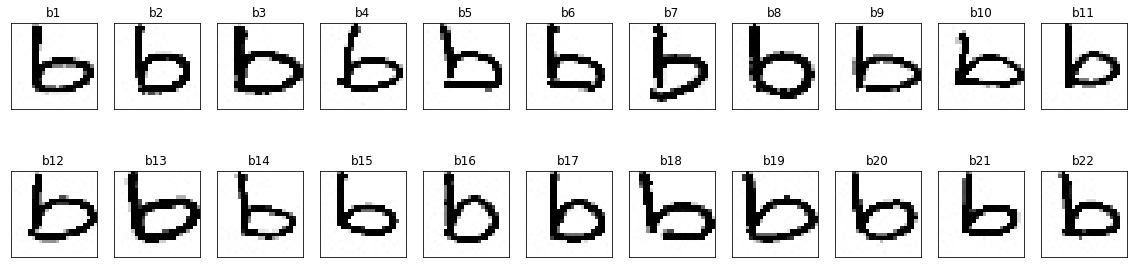

In [11]:
plt.figure(figsize=(20, 5))
for i in range(1,23):
    img = cv.imread('b{}.jpg'.format(i), cv.IMREAD_GRAYSCALE)
    plt.subplot(2,11,i), plt.title('b{}'.format(i))
    plt.imshow(img, cmap='gray'), plt.xticks([]), plt.yticks([])

plt.show()

## Outras letras
As imagens abaixo foram cortadas de uma foto e não foram redimensionadas.

* a
![](img/a.gif) 
* b
![](img/b.gif) 
* c
![](img/c.gif) 
* d
![](img/d.gif) 
* e 
![](img/e.gif)
* f
![](img/f.gif)
* i
![](img/i.gif)
* o
![](img/o.gif)
* u
![](img/u.gif)

## Melhorias
* Reduzir quantidade de pontos fornecidos ao KMeans
* Aumentar número de amostras sempre que possível
* Usar FloodFill para encontrar quantidade de letras e seus centros

# Rede Neural (TODO)

In [12]:
import keras as ks

Using TensorFlow backend.


In [13]:
x_treino = []
y_treino = []

ind = 0
for letra in ['a','b','c','d','e','f','i','o','u']:
    for i in range(50):
        nome = '/home/victor/Documentos/Spyder/OpenCV/'+letra+str(i)+'.jpg'
        img = cv.imread(nome, cv.IMREAD_GRAYSCALE)
        x_treino.append(img)
        y_treino.append(ind)
    ind+=1
x_treino = np.array(x_treino)    
y_treino = np.array(y_treino)

Tamanho da lista de treinamento: 450


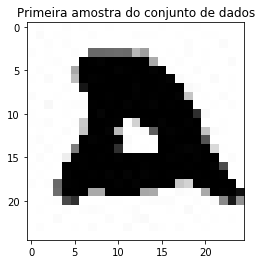

In [14]:
print('Tamanho da lista de treinamento: '+str(len(x_treino)))
#print('Tamanho da lista de validação: '+str(len(x_teste)))
plt.imshow(x_treino[0], cmap='gray'), plt.title('Primeira amostra do conjunto de dados')
plt.show()

In [18]:
model = ks.models.Sequential()
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(128, activation='sigmoid'))
model.add(ks.layers.Dense(9, activation='softmax'))
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

monitor = ks.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')

H = model.fit(x_treino, y_treino, epochs=100, batch_size=3, callbacks=[monitor])


Epoch 1/100
450/450 [==============================] - 2s 4ms/step - loss: 2.2809 - acc: 0.1289
Epoch 2/100
450/450 [==============================] - 1s 3ms/step - loss: 2.1233 - acc: 0.2022
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 2.0282 - acc: 0.3133
Epoch 4/100
450/450 [==============================] - 1s 2ms/step - loss: 1.9500 - acc: 0.3378
Epoch 5/100
450/450 [==============================] - 1s 2ms/step - loss: 1.8780 - acc: 0.4044
Epoch 6/100
450/450 [==============================] - 1s 2ms/step - loss: 1.7749 - acc: 0.4489
Epoch 7/100
450/450 [==============================] - 1s 3ms/step - loss: 1.7670 - acc: 0.4956
Epoch 8/100
450/450 [==============================] - 1s 2ms/step - loss: 1.7077 - acc: 0.5289
Epoch 9/100
450/450 [==============================] - 1s 2ms/step - loss: 1.6519 - acc: 0.5000
Epoch 10/100
450/450 [==============================] - 1s 3ms/step - loss: 1.4848 - acc: 0.6222
Epoch 11/100
450/450 [=================

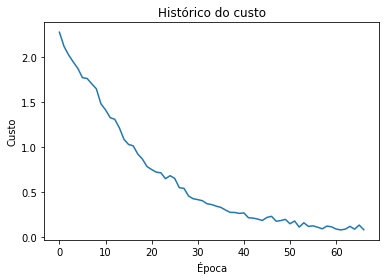

In [20]:
plt.plot(H.history['loss'])
plt.title('Histórico do custo')
plt.xlabel('Época')
plt.ylabel('Custo')
plt.show()

rotulo: [0]


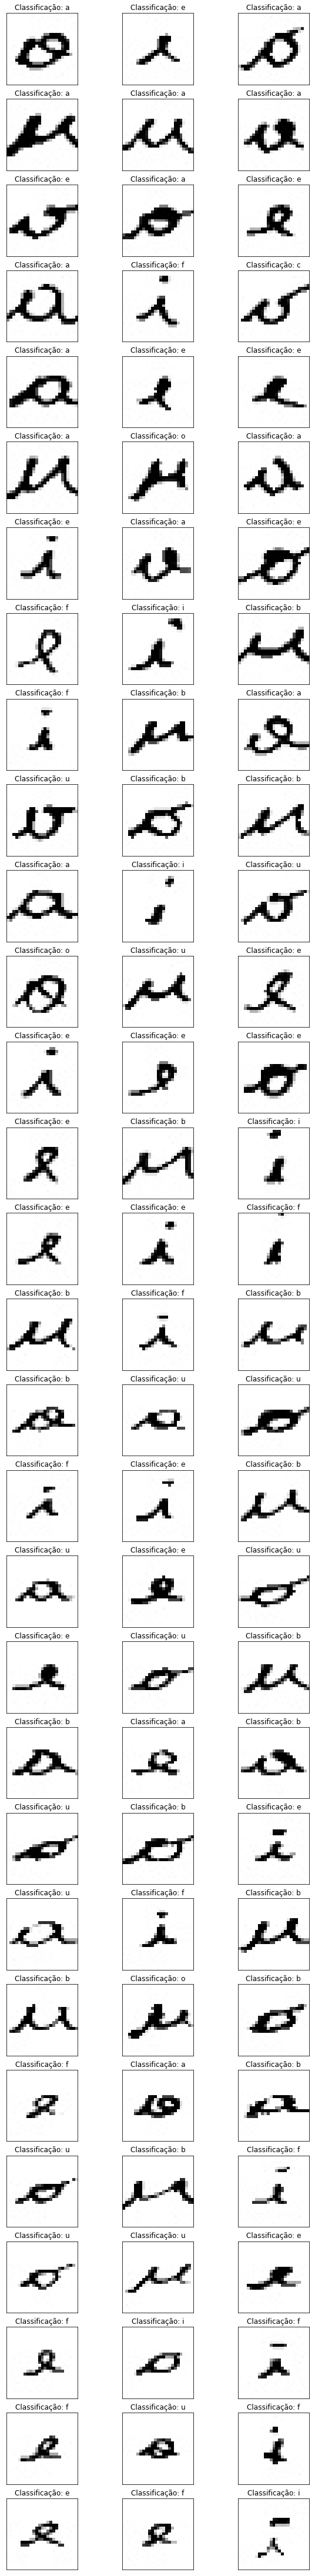

In [21]:
letras = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'i', 7:'o', 8:'u'}

r = model.predict_classes(np.array([x_treino[0]]))
print('rotulo: '+str(r))

plt.figure(figsize=(10,80)) # largura, altura
for i in range(90):
    nome = '/home/victor/Documentos/Spyder/OpenCV/teste/vogal '+str(i)+'.jpg'
    img = cv.imread(nome, cv.IMREAD_GRAYSCALE)
    rotulo = letras[model.predict_classes(np.array([img]))[0]]  # rótulo alfabético
    plt.subplot(30, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title('Classificação: '+rotulo), plt.xticks([]), plt.yticks([])
plt.show()